<a href="https://colab.research.google.com/github/goitstudent123/ml-fundamentals-and-applications/blob/main/dz_topic_4_HAS.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [26]:
# 1. Здійсніть імпорт необхідних пакетів.
import os
from pathlib import Path

import numpy as np
import pandas as pd

import kagglehub

from sklearn.impute import SimpleImputer
from sklearn.preprocessing import OneHotEncoder, StandardScaler
from sklearn.compose import ColumnTransformer
from sklearn.pipeline import Pipeline
from sklearn.linear_model import LogisticRegression
from sklearn.metrics import classification_report


In [27]:
# 2. Завантажте набір даних Rain in Australia.
os.environ["KAGGLEHUB_API_TOKEN"] = os.environ.get("KAGGLEHUB_API_TOKEN", "KGAT_1b4b7a2d367078229fec421af54885f2")

dataset_dir = Path(kagglehub.dataset_download("jsphyg/weather-dataset-rattle-package"))
candidate_files = list(dataset_dir.rglob("*.csv")) + list(dataset_dir.rglob("*.csv.gz"))

if not candidate_files:
    raise FileNotFoundError(f"No .csv/.csv.gz files found under: {dataset_dir}")

data_path = max(candidate_files, key=lambda p: p.stat().st_size)
data = pd.read_csv(data_path)

print("Dataset dir:", dataset_dir)
print("Loaded file:", data_path.name)
print("Shape:", data.shape)
data.head()


Using Colab cache for faster access to the 'weather-dataset-rattle-package' dataset.
Dataset dir: /kaggle/input/weather-dataset-rattle-package
Loaded file: weatherAUS.csv
Shape: (145460, 23)


,Date,Location,MinTemp,MaxTemp,Rainfall,Evaporation,Sunshine,WindGustDir,WindGustSpeed,WindDir9am,...,Humidity9am,Humidity3pm,Pressure9am,Pressure3pm,Cloud9am,Cloud3pm,Temp9am,Temp3pm,RainToday,RainTomorrow
0,2008-12-01,Albury,13.4,22.9,0.6,NaN,NaN,W,44.0,W,...,71.0,22.0,1007.7,1007.1,8.0,NaN,16.9,21.8,No,No
1,2008-12-02,Albury,7.4,25.1,0.0,NaN,NaN,WNW,44.0,NNW,...,44.0,25.0,1010.6,1007.8,NaN,NaN,17.2,24.3,No,No
2,2008-12-03,Albury,12.9,25.7,0.0,NaN,NaN,WSW,46.0,W,...,38.0,30.0,1007.6,1008.7,NaN,2.0,21.0,23.2,No,No
3,2008-12-04,Albury,9.2,28.0,0.0,NaN,NaN,NE,24.0,SE,...,45.0,16.0,1017.6,1012.8,NaN,NaN,18.1,26.5,No,No
4,2008-12-05,Albury,17.5,32.3,1.0,NaN,NaN,W,41.0,ENE,...,82.0,33.0,1010.8,1006.0,7.0,8.0,17.8,29.7,No,No


In [28]:
# 3. Виконайте коректне розділення набору даних на тренувальну і тестову вибірки, а також перегляньте обробку часових ознак для навчання моделі.

missing_rate = data.isna().mean()
# Видаліть із набору ознаки з великою кількістю пропущених значень.
columns_to_keep = missing_rate[missing_rate < 0.35].index
data = data.loc[:, columns_to_keep].copy()

data = data.dropna(subset=["RainTomorrow"]).copy()

# Створіть підмножини набору даних із числовими та категоріальними ознаками.
data_num = data.select_dtypes(include=[np.number]).copy()
data_cat = data.select_dtypes(include=["object"]).copy()

# Змініть тип колонки Date на тип datetimeі створіть додаткові колонки Year та Month.
data_cat["Date"] = pd.to_datetime(data_cat["Date"])
data_cat["Year"] = data_cat["Date"].dt.year
data_cat["Month"] = data_cat["Date"].dt.month.astype(str)
data_cat = data_cat.drop(columns=["Date"])

# Переміcтить створену нову колонку Year з підмножини набору із категоріальними ознаками до підмножини із числовими ознаками.
data_num["Year"] = data_cat.pop("Year").astype(int)

y = data_cat.pop("RainTomorrow")
X_num = data_num
X_cat = data_cat

# Розбийте підмножини на тренувальну і тестову вибірки за такою логікою: до тестової вибірки віднесіть всі об'єкти із
# набору даних із останнім (максимальним) роком спостережень, а для навчання моделі залиште всі інші об'єкти.
max_year = X_num["Year"].max()
test_mask = X_num["Year"] == max_year

X_train_num = X_num.loc[~test_mask].copy()
X_test_num = X_num.loc[test_mask].copy()

X_train_cat = X_cat.loc[~test_mask].copy()
X_test_cat = X_cat.loc[test_mask].copy()

y_train = y.loc[~test_mask].copy()
y_test = y.loc[test_mask].copy()

print("Max year (test year):", max_year)
print("Train size:", len(y_train), "Test size:", len(y_test))


Max year (test year): 2017
Train size: 133727 Test size: 8466


In [29]:
# 4. Відновіть пропущені дані за допомогою об'єкта SimpleImputer з пакету sklearn.
# 5. Нормалізуйте числові ознаки за допомогою об'єкта StandardScaler з пакету sklearn.
numeric_features = X_train_num.columns.tolist()
categorical_features = X_train_cat.columns.tolist()


numeric_pipeline = Pipeline(
    steps=[
        ("imputer", SimpleImputer(strategy="median")),   # fill missing numeric values with median
        ("scaler", StandardScaler()),                    # Task 5: normalize numeric features
    ]
)

# 6. Виконайте кодування категоріальних ознак за допомогою об’єкта OneHotEncoder з пакету sklearn.
categorical_pipeline = Pipeline(
    steps=[
        ("imputer", SimpleImputer(strategy="most_frequent")),  # fill missing categorical values with mode
        ("onehot", OneHotEncoder(handle_unknown="ignore", sparse_output=False)),  # Task 6: one-hot encode categorical features
    ]
)

# 7. Об'єднайте підмножини з числовими і категоріальними ознаками (після кодування) для побудови моделі за допомогою об’єкта LogisticRegression з пакету sklearn.
preprocess = ColumnTransformer(
    transformers=[
        ("num", numeric_pipeline, numeric_features),
        ("cat", categorical_pipeline, categorical_features),
    ],
    remainder="drop",
)

clf = Pipeline(
    steps=[
        ("preprocess", preprocess),  # apply imputing, scaling, and encoding
        ("model", LogisticRegression(
            solver="liblinear",      # stable solver for binary classification
            max_iter=2000,
            random_state=42
        )),
    ]
)

X_train = pd.concat([X_train_num, X_train_cat], axis=1)
X_test = pd.concat([X_test_num, X_test_cat], axis=1)

clf.fit(X_train, y_train)

# Predict on test set
y_pred = clf.predict(X_test)


In [30]:
# 8. Розрахуйте метрики нової моделі за допомогою методу classification_report() з пакета sklearn
print(classification_report(y_test, y_pred))


              precision    recall  f1-score   support

          No       0.87      0.95      0.91      6703
         Yes       0.72      0.44      0.55      1763

    accuracy                           0.85      8466
   macro avg       0.79      0.70      0.73      8466
weighted avg       0.83      0.85      0.83      8466



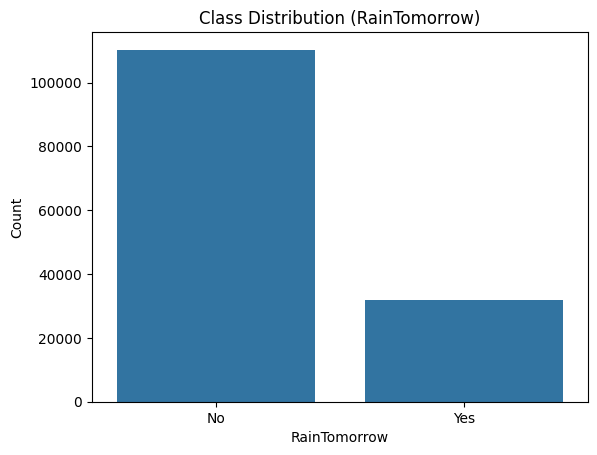

In [31]:
# Class distribution (shows dataset imbalance)
import matplotlib.pyplot as plt
import seaborn as sns

plt.figure()
sns.countplot(x=y)
plt.title("Class Distribution (RainTomorrow)")
plt.xlabel("RainTomorrow")
plt.ylabel("Count")
plt.show()


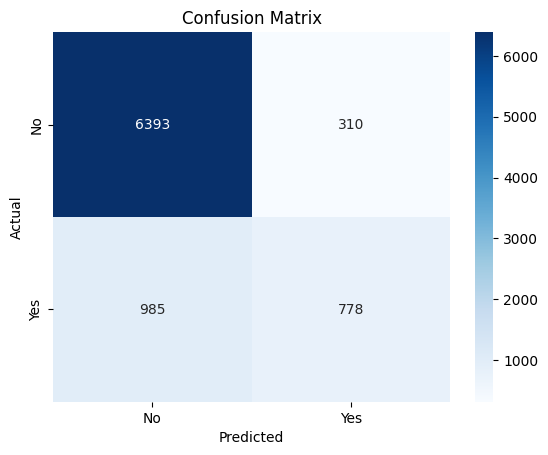

In [32]:
# Confusion Matrix (shows model prediction structure)
from sklearn.metrics import confusion_matrix

cm = confusion_matrix(y_test, y_pred)

plt.figure()
sns.heatmap(cm, annot=True, fmt="d", cmap="Blues",
            xticklabels=["No", "Yes"],
            yticklabels=["No", "Yes"])
plt.title("Confusion Matrix")
plt.xlabel("Predicted")
plt.ylabel("Actual")
plt.show()


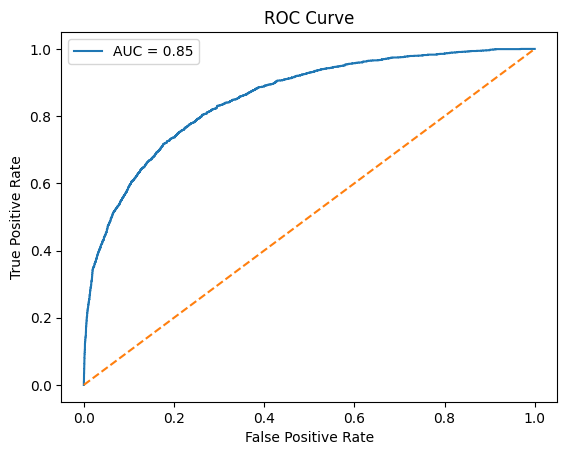

In [33]:
# ROC Curve (shows model discrimination ability)
from sklearn.metrics import roc_curve, roc_auc_score

y_prob = clf.predict_proba(X_test)[:, 1]

fpr, tpr, _ = roc_curve(y_test, y_prob, pos_label="Yes")
roc_auc = roc_auc_score(y_test, y_prob)

plt.figure()
plt.plot(fpr, tpr, label=f"AUC = {roc_auc:.2f}")
plt.plot([0, 1], [0, 1], linestyle="--")
plt.title("ROC Curve")
plt.xlabel("False Positive Rate")
plt.ylabel("True Positive Rate")
plt.legend()
plt.show()


**Порівняння метрик**

Референсні значення (базова логістична регресія з випадковим розбиттям):
* Accuracy ≈ 0.84–0.85
* F1-score для класу "No" ≈ 0.90
* F1-score для класу "Yes" ≈ 0.55–0.57
* Macro F1 ≈ 0.73–0.74

Нова модель (з часовим розбиттям):
* Accuracy = 0.85
* F1 (No) = 0.91
* F1 (Yes) = 0.55
* Macro F1 = 0.73
* Weighted F1 = 0.83

**Висновки**

* Accuracy практично не змінилася
Це означає, що модель однаково добре працює як при випадковому розбитті, так і при більш реалістичному часовому тестуванні.
* Якість для класу "No" залишилась високою
F1 ≈ 0.91 — стабільний показник.
* Якість для класу "Yes" майже не змінилась
F1 ≈ 0.55 — це типовий результат для незбалансованого датасету.
* Macro F1 практично ідентичний
Це означає, що баланс між класами модель зберігає.

Результати нової моделі практично співпадають з результатами базової моделі.
Незважаючи на більш строгий підхід до розбиття даних (тестування на останньому році спостережень), модель демонструє:
* стабільність,
* відсутність явного переобучення,
* здатність узагальнювати на новому часовому періоді.
Це свідчить про те, що логістична регресія є достатньо надійною базовою моделлю для задачі прогнозування дощу.

Порівняння показало, що результати моделі з часовим розбиттям є співставними з результатами моделі, отриманої при стандартному розбитті вибірки. Незначні відмінності в метриках підтверджують стабільність моделі та її здатність до узагальнення на нових даних. Отримана точність 85% свідчить про достатню якість прогнозування для базового класифікатора.